# A Study of Age-Related Changes from 1998 to 2018 and Predictions for the Future

**Author:** Xiaolin Liu

The following sections will detail how this study was conducted through data processing, model building, and prediction results. First, the data source is  at [UK Data Service](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340), where historical data from the National Travel Survey and usage guidelines can be downloaded. The data is available in three formats: SPSS, STATA, and TAB. In this example, we use the TAB forThis notebook examines the changes in transportation modes among young people. Similar analyses can be performed for older adults by modifying the dataset to reflect their age group. This approach allows for exploration of how transportation preferences and behaviors may differ across different age demographics.mat.


## I. Data Processing

First, set up the environment by installing the necessary libraries, packages, and functions.


In [4]:
#If you encounter any issues with package versions or compatibility, you might need to specify version constraints. 
#For example, if you're using TensorFlow 2.x, you might need to ensure compatibility with other libraries.

#!pip install pandas numpy matplotlib scikit-learn tensorflow statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers, models

The data tables required for this study include `household`, `individual`, `vehicle`, and `trip`. These tables record information about respondents' travel behaviour patterns, modes of transport, distance, frequency, age, income level, education level, and exposure to different transport modes. This includes access to public transport, private cars, and bicycles.


In [5]:
# Define a function to read a large file in chunks from a zip archive into a DataFrame
def read_tab_from_zip(zip_file_path, file_path, delimiter='\t', chunksize=None):
    """
    Read a tab-delimited file from a zip archive into a DataFrame.

    Parameters:
    - zip_file_path (str): Path to the zip file.
    - file_path (str): Path to the file within the zip archive.
    - delimiter (str): Delimiter used in the file (default is tab '\t').
    - chunksize (int): Number of rows per chunk (default is None, meaning read whole file at once).

    Returns:
    - DataFrame: The DataFrame containing the data from the specified file.
    """
    if chunksize:
        chunks = []
        with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
            with zip_file.open(file_path) as file:
                for chunk in pd.read_csv(file, delimiter=delimiter, chunksize=chunksize):
                    chunks.append(chunk)
        return pd.concat(chunks, ignore_index=True)
    else:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
            with zip_file.open(file_path) as file:
                return pd.read_csv(file, delimiter=delimiter)


In [6]:
# Read each dataset using the defined function for data from 2002-2022
household = read_tab_from_zip('2002-2022.zip', 'UKDA-5340-tab/tab/household_eul_2002-2022.tab')

In [7]:
individual = read_tab_from_zip('2002-2022.zip', 'UKDA-5340-tab/tab/individual_eul_2002-2022.tab')

In [8]:
vehicle = read_tab_from_zip('2002-2022.zip', 'UKDA-5340-tab/tab/vehicle_eul_2002-2022.tab')

In [9]:
trip = read_tab_from_zip('2002-2022.zip', 'UKDA-5340-tab/tab/trip_eul_2002-2022.tab', chunksize=10000)

In [10]:
# Data Preparation
household_1 = household[['HouseholdID', 'SurveyYear', 'HHoldCVAvail_B01ID','BusStandard_B01ID']]
vehicle_1 = vehicle[['IndividualID', 'SurveyYear', 'VehAvail_B01ID']]
trip_1 = trip[['IndividualID', 'SurveyYear', 'MainMode_B04ID','TripDisIncSW','TripTravTime']]
individual_1=individual[['HouseholdID','IndividualID','Age_B01ID','SurveyYear',
                         'OrdBusFreq_B01ID','BicycleFreq_B01ID','WalkFreq_B01ID',
                         'OwnCycle_B01ID','DrivLic_B02ID','CarAccess_B01ID',
                         'IndIncome2002_B02ID','EcoStat_B03ID']]

In [11]:
# Now use the function to read the data from 1995-2001
household90 = read_tab_from_zip('1995-2001.zip', 'UKDA-6108-tab/tab/household.tab')
individual90 = read_tab_from_zip('1995-2001.zip', 'UKDA-6108-tab/tab/individual.tab')
vehicle90 = read_tab_from_zip('1995-2001.zip', 'UKDA-6108-tab/tab/vehicle.tab')
trip90 = read_tab_from_zip('1995-2001.zip', 'UKDA-6108-tab/tab/trip.tab', chunksize=10000)

# Quickly inspect a small subset of the data 
print(individual90.sample(n=15, random_state=2487))
print(individual90.columns)

/tmp/ipykernel_146640/3444260772.py:25: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file, delimiter=delimiter)


       SurveyYear  IndividualID  HouseholdID       PSUID VehicleID  PersNo  \
23576        1997    1997006230   1997002542  1997000180                 4   
48292        2000    2000006546   2000002726  2000000187                 4   
3564         1995    1995003565   1995001449  1995000097                 1   
24456        1997    1997007110   1997002904  1997000204                 1   
6016         1995    1995006017   1995002448  1995000163                 3   
48043        2000    2000006297   2000002627  2000000181                 1   
27492        1998    1998001698   1998000690  1998000058                 1   
24970        1997    1997007624   1997003120  1997000218                 2   
13981        1996    1996005081   1996002123  1996000148                 4   
9970         1996    1996001070   1996000463  1996000035                 3   
33104        1998    1998007310   1998003036  1998000221                 1   
36597        1999    1999002840   1999001180  1999000085        

### I.2: Handling Missing Data and Variable Definition

During the analysis, we discovered that the dataset from 1998 does not include information on the frequency of walking trips (`walkfreq`). This results in a missing variable, which impacts our modeling process. To address this issue, we propose the following approach:

1. **Handling Missing `walkfreq` Data**:
    - For the year 1998, since the `walkfreq` variable is missing, we will fill this variable with zeros for all records. This approach assumes that walking frequency was not recorded, and setting it to zero allows us to include 1998 in our models without the need for complex imputation methods.

2. **Model Building**:
    - **Model 1**: We will first build a model using data from 2003 to 2018. This model will serve as a baseline for comparison.
    - **Model 2**: We will then build a second model using the data from 1998 to 2018, where the `walkfreq` variable has been filled with zeros for 1998. This allows us to analyze how including the filled data from 1998 affects the results.

3. **Addressing Missing Variables Across Different Years**:
    - We observed that missing data issues are not limited to 1998. For example:
        - **1998-2001**: Missing data on trip frequencies.
    ,**2004**    - **2002**: Missing data on travel modes.
    - To effectively handle these issues and avoid biases in our models, we define our input data in five-year intervals. This approach helps to mitigate the problems associated with missing data by grouping and summarising the data over consistent periods, reducing the impact of missing variables.

By adopting this approach, we aim to improve the robustness of our analysis and ensure that missing data does not unduly influence the results of our models.


In [12]:
# Data Preparation
household_2 = household90[['HouseholdID', 'SurveyYear', 'HHoldCVAvail_B01ID','BusStandard_B01ID']]
vehicle_2 = vehicle90[['IndividualID', 'SurveyYear', 'VehAvail_B01ID']]
trip_2 = trip90[['IndividualID', 'SurveyYear', 'MainMode_B04ID','TripDisIncSW','TripTravTime']]
individual_2=individual90[['HouseholdID','IndividualID','Age_B01ID','SurveyYear',
                         'OrdBusFreq_B01ID','BicycleFreq_B01ID',
                         'OwnCycle_B01ID','DrivLic_B02ID','CarAccess_B01ID',
                         'IndIncome1995_B02ID','EcoStat_B03ID']]

# Filter dataset to data about individuals who were between 15 and 20 years old in 1998. 
individual_2=individual_2[(individual_2['SurveyYear'] == 1998) & (individual_2['Age_B01ID'] >= 6) & (individual_2['Age_B01ID'] <= 10)]

# Quickly inspect a small subset of the data and values of variables
print(individual_2.sample(n=15, random_state=2487))
print(individual_2['OrdBusFreq_B01ID'].unique())

       HouseholdID  IndividualID  Age_B01ID  SurveyYear  OrdBusFreq_B01ID  \
31905   1998002568    1998006111          7        1998                 1   
27718   1998000779    1998001924         10        1998                 7   
28128   1998000943    1998002334          8        1998                 7   
32231   1998002679    1998006437          6        1998                 1   
32990   1998002983    1998007196          9        1998                 6   
30114   1998001791    1998004320         10        1998                 1   
33453   1998003181    1998007659         10        1998                 7   
31520   1998002413    1998005726          8        1998                 1   
27723   1998000781    1998001929          6        1998                -8   
32300   1998002709    1998006506          9        1998                 1   
28818   1998001245    1998003024          7        1998                 7   
25874   1998000036    1998000080         10        1998                 1   

In [13]:
# Filter dataset to data about individuals who were between 20 and 39 years old in 2002 to 2022. 
condition_2008 = (individual_1['SurveyYear'] == 2008) & (individual_1['Age_B01ID'] == 12)
condition_2018 = (individual_1['SurveyYear'] == 2018) & (individual_1['Age_B01ID'].isin([13]))
condition_2003 = (individual_1['SurveyYear'] == 2003) & (individual_1['Age_B01ID'].isin([11]))
condition_2013 = (individual_1['SurveyYear'] == 2013) & (individual_1['Age_B01ID'].isin([13]))
individual_3 = individual_1[condition_2003 | condition_2008 | condition_2013 | condition_2018]

# Quickly inspect a small subset of the data and values of variables
print(individual_3.sample(n=15, random_state=2487))
print(individual_3['WalkFreq_B01ID'].unique())

        HouseholdID  IndividualID  Age_B01ID  SurveyYear  OrdBusFreq_B01ID  \
247040   2013002566    2013006215         13        2013                 5   
26322    2003004007    2003009728         11        2003                 2   
247177   2013000292    2013000681         13        2013                 6   
250391   2013002152    2013005197         13        2013                 3   
241676   2013004413    2013010610         13        2013                 1   
133929   2008003328    2008007856         12        2008                 7   
138579   2008000962    2008002242         12        2008                 7   
21909    2003009115    2003021781         11        2003                 1   
21915    2003009117    2003021787         11        2003                 7   
335231   2018000052    2018000107         13        2018                 3   
237278   2013005523    2013013244         13        2013                 7   
151451   2008007967    2008018868         12        2008        

In [14]:
# Merge different DataFrames using common keys (HouseholdID and IndividualID).
# For 1998.
combined901 = pd.merge(individual_2, household_2, on='HouseholdID', how='inner')
combined902 = pd.merge(combined901, trip_2, on='IndividualID', how='inner')
# For 2003-2018
combined3 = pd.merge(individual_3, household_1, on='HouseholdID', how='inner')
combined4 = pd.merge(combined3, trip_1, on='IndividualID', how='inner')
print(combined902.head(15))
print(combined4.head(15))

    HouseholdID  IndividualID  Age_B01ID  SurveyYear_x  OrdBusFreq_B01ID  \
0    1998000015    1998000035         10          1998                 1   
1    1998000015    1998000035         10          1998                 1   
2    1998000015    1998000035         10          1998                 1   
3    1998000015    1998000035         10          1998                 1   
4    1998000015    1998000035         10          1998                 1   
5    1998000015    1998000035         10          1998                 1   
6    1998000015    1998000035         10          1998                 1   
7    1998000015    1998000035         10          1998                 1   
8    1998000015    1998000035         10          1998                 1   
9    1998000015    1998000035         10          1998                 1   
10   1998000015    1998000035         10          1998                 1   
11   1998000015    1998000035         10          1998                 1   
12   1998000

In [15]:
# 'yth98' includes relevant information such as IDs, age, survey year, economic status,
# frequency of using various transport modes, and trip details for the year 1998.
yth98=combined902[['HouseholdID','IndividualID','Age_B01ID','SurveyYear','EcoStat_B03ID',
                         'OrdBusFreq_B01ID','BicycleFreq_B01ID',
                         'OwnCycle_B01ID','DrivLic_B02ID','CarAccess_B01ID',
                         'IndIncome1995_B02ID','MainMode_B04ID','TripDisIncSW',
                   'BusStandard_B01ID']]

# Same as ‘yth0318’ 
yth0318 = combined4[['HouseholdID','IndividualID','Age_B01ID','SurveyYear','EcoStat_B03ID',
                         'OrdBusFreq_B01ID','BicycleFreq_B01ID','WalkFreq_B01ID',
                         'OwnCycle_B01ID','DrivLic_B02ID','CarAccess_B01ID',
                         'IndIncome2002_B02ID','MainMode_B04ID','TripDisIncSW',
                   'BusStandard_B01ID']]

In [16]:
# Rename columns in DataFrame for better readability
yth98=yth98.rename(columns={
    'SurveyYear': 'survey_year',
    'OwnCycle_B01ID': 'own_cycle',
    'DrivLic_B02ID': 'driver_license',
    'CarAccess_B01ID': 'car_access',
    'IndIncome1995_B02ID': 'individual_income',
    'EcoStat_B03ID':'eco_stat',
    'MainMode_B04ID': 'main_mode',
    'TripDisIncSW':'trip_dis',
    'OrdBusFreq_B01ID':'ordbusfreq',
    'BicycleFreq_B01ID':'bicyclefreq',
    'BusStandard_B01ID':'bus_standard'
})
yth0318 =yth0318.rename(columns={
    'SurveyYear': 'survey_year',
    'OwnCycle_B01ID': 'own_cycle',
    'DrivLic_B02ID': 'driver_license',
    'CarAccess_B01ID': 'car_access',
    'IndIncome2002_B02ID': 'individual_income',
    'EcoStat_B03ID':'eco_stat',
    'MainMode_B04ID': 'main_mode',
    'TripDisIncSW':'trip_dis',
    'OrdBusFreq_B01ID':'ordbusfreq',
    'BicycleFreq_B01ID':'bicyclefreq',
    'WalkFreq_B01ID':'walkfreq',
    'BusStandard_B01ID':'bus_standard'
    })

In [17]:
# Fill missing 'walkfreq' data for the year 1998 with -9, indicating missing or not applicable data
yth98['walkfreq'] = -9

# Concatenate the data from 1998 and 2003-2018 into a single DataFrame 'yth20'
yth20 = pd.concat([yth0318, yth98], ignore_index=True)

# Quickly inspect the combined data and ensure it looks correct
print(yth20.sample(n=15, random_state=2487))

# Identify and print records where the 'main_mode' column has errors or anomalies in the data
negative_values = yth20[yth20['main_mode'] < 0]
print(negative_values)

       HouseholdID  IndividualID  Age_B01ID  survey_year  eco_stat  \
11852   2003002951    2003007200         11         2003         1   
82101   2018006298    2018014997         13         2018         1   
63318   2018000355    2018000852         13         2018         1   
70899   2018006278    2018014938         13         2018         1   
79303   2018005047    2018012012         13         2018         1   
21500   2008002617    2008006170         12         2008         1   
74227   2018000925    2018002269         13         2018         4   
74555   2018002234    2018005337         13         2018         1   
52170   2013007196    2013017287         13         2013         2   
4683    2003002340    2003005716         11         2003         1   
56791   2013002884    2013006962         13         2013         4   
25292   2008001671    2008003911         12         2008         1   
32238   2013002995    2013007216         13         2013         1   
43683   2013003409  

In [18]:
# Calculate the frequency counts of unique values for 'ordbusfreq' and 'bicyclefreq' and 'walkfreq'
# This gives a summary of how many times each value appears in the dataset for each of these columns

ordbusfreq_counts = yth20['ordbusfreq'].value_counts()
bicyclefreq_counts = yth20['bicyclefreq'].value_counts()
walkfreq_counts = yth20['walkfreq'].value_counts()
print("OrdBusFreq Value Counts:")
print(ordbusfreq_counts)

print("\nBicycleFreq Value Counts:")
print(bicyclefreq_counts)

print("\nWalkFreq Value Counts:")
print(walkfreq_counts)

print(yth20.shape)

OrdBusFreq Value Counts:
ordbusfreq
 7    43452
 1    13667
 6    10211
 2     8223
 5     8127
 4     7634
 3     4120
-9      661
-8       97
Name: count, dtype: int64

BicycleFreq Value Counts:
bicyclefreq
-10    29580
 7     22092
-9     19595
 1      4277
 5      4191
 2      3955
 4      3623
 6      3388
-8      2969
 3      2522
Name: count, dtype: int64

WalkFreq Value Counts:
walkfreq
 1    38685
 2    21024
 7    12953
-9     6762
 4     6370
 3     5372
 5     2880
 6     1911
-8      235
Name: count, dtype: int64
(96192, 15)


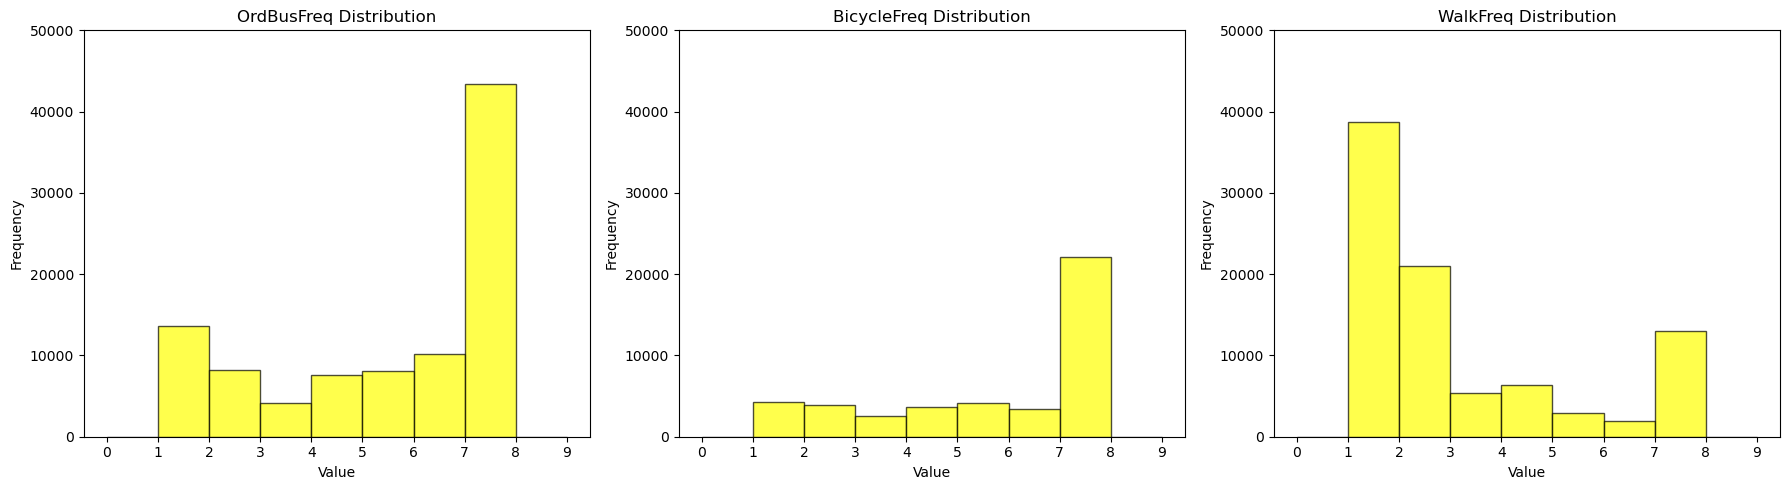

In [19]:
# Define the range for the x-axis and bins
x_range = range(0, 9)  # From -10 to 8 inclusive
bin_edges = [x for x in range(0, 10, 1)]  # Define bin edges with an interval of 2

# Set a common y-axis limit based on the maximum frequency among the histograms
common_y_limit = 50000

# Plot histogram for 'ordbusfreq'
plt.figure(figsize=(18, 5))  # Set figure size
plt.subplot(1, 3, 1)  # Create a subplot for the first histogram
plt.hist(yth20['ordbusfreq'].dropna(), bins=bin_edges, color='yellow', edgecolor='black', alpha=0.7)
plt.title('OrdBusFreq Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(bin_edges)  # Set x-axis ticks to match the bin edges
plt.ylim(0, common_y_limit)  # Set the y-axis limit to the common limit

# Plot histogram for 'bicyclefreq'
plt.subplot(1, 3, 2)  # Create a subplot for the second histogram
plt.hist(yth20['bicyclefreq'].dropna(), bins=bin_edges, color='yellow', edgecolor='black', alpha=0.7)
plt.title('BicycleFreq Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(bin_edges)  # Set x-axis ticks to match the bin edges
plt.ylim(0, common_y_limit)  # Set the y-axis limit to the common limit

# Plot histogram for 'walkfreq'
plt.subplot(1, 3, 3)  # Create a subplot for the third histogram
plt.hist(yth20['walkfreq'].dropna(), bins=bin_edges, color='yellow', edgecolor='black', alpha=0.7)
plt.title('WalkFreq Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(bin_edges)  # Set x-axis ticks to match the bin edges
plt.ylim(0, common_y_limit)  # Set the y-axis limit to the common limit

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### I.3: Data Processing Explanation

During the data processing phase, I encountered several challenges, primarily related to missing values and overly complex categorical variables. To address these issues effectively, I employed the following strategies:

1. **Mapping and Reclassification**:
   - Many variables contained missing or overly detailed categories that could complicate the analysis. To simplify the data, I remapped these variables into more manageable and meaningful categories. This process involved combining similar categories or reclassifying the data into broader groups, thereby reducing complexity and making the data more suitable for modelling.

2. **Conversion of Categorical Variables to Numerical Values**:
   - For variables such as **income level** and **travel frequency**, which were originally categorical, I converted them into numerical values. This step is crucial for the following reasons:
     - **Income Level**: By assigning numerical values to different income brackets, I enabled the model to interpret income as a continuous or ordinal variable, which can enhance the model's ability to capture trends related to income variations.
     - **Travel Frequency**: Similarly, converting travel frequency categories into numerical values allowed the model to better understand the relationship between frequency and other variables, as numerical data often performs better in regression models.

By simplifying the data and transforming categorical variables into numerical ones, I aimed to make the dataset more robust and conducive to accurate model predictions. These preprocessing steps are critical to improving the overall quality of the analysis and ensuring that the logistic regression model can effectively learn from the data.


In [20]:
#20years data
yth20['own_cycle'] = np.where(yth20['own_cycle'].isin([1,2,3]), 1, 0)
yth20['driver_license'] = np.where(yth20['driver_license'] == 1, 1, 0)
yth20['car_access'] = np.where(yth20['car_access'].isin([1,2,3,4]), 1, 0)
yth20['individual_income'] = np.where(yth20['individual_income'] == 1, 25000, 
                                        np.where(yth20['individual_income'] == 2, 37500,
                                                 np.where(yth20['individual_income'] == 3, 50000, 0)))
yth20['eco_stat'] = np.where(yth20['eco_stat'].isin([-8, -9, -10]), 0, yth20['eco_stat'])
yth20['bus_standard'] = np.where(yth20['bus_standard']== 1,1,0)
main_mode_mapping_1998 = {
    1: 1, 2: 1,
    3: 3, 4: 3, 12: 3,
    5: 4,
    7: 5, 8: 5, 9: 5, 10: 5,
    11: 6,
    6: 7, 13: 7,
    -8: 0
}
main_mode_mapping_0818 = {
    1: 1, 2: 1,
    3: 2, 32: 2,
    5: 3, 6: 3, 7: 3, 8: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 26: 3, 27: 3,
    9: 4, 10: 4, 11: 4, 12: 4,
    4: 5, 18: 5, 19: 5, 20: 5, 21: 5, 22: 5,
    23: 6, 24: 6,
    -10: 0, 31: 0
}
def map_main_mode(row):
    if row['survey_year'] == 1998:
        return main_mode_mapping_1998.get(row['main_mode'], 7) 
    else:
        return main_mode_mapping_0818.get(row['main_mode'], 7) 

yth20['main_mode'] = yth20.apply(map_main_mode, axis=1)

trip_dis_mapping = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 10, 7: 20, 8: 30, 9: 50, 10: 100, 11: 150, 12: 200
}
yth20['trip_dis'] = yth20['trip_dis'].replace(trip_dis_mapping).fillna(0).astype(int)

freq_mapping = {
    1: 260, 2: 78, 3: 50, 4: 18, 5: 7, 6: 1.5,-8:0,-9:0,-10:0
}

yth20['ordbusfreq'] = yth20['ordbusfreq'].replace(freq_mapping).fillna(0).astype(float)
yth20['bicyclefreq'] = yth20['bicyclefreq'].replace(freq_mapping).fillna(0).astype(float)
yth20['walkfreq'] = yth20['walkfreq'].replace(freq_mapping).fillna(0).astype(float)
print(yth20['main_mode'].unique())

[2 3 4 1 5 7 6]


In [21]:
#15years data
yth0318['own_cycle'] = np.where(yth0318['own_cycle'].isin([1,2,3]), 1, 0)
yth0318['driver_license'] = np.where(yth0318['driver_license'] == 1, 1, 0)
yth0318['car_access'] = np.where(yth0318['car_access'].isin([1,2,3,4]), 1, 0)
yth0318['individual_income'] = np.where(yth0318['individual_income'] == 1, 25000, 
                                        np.where(yth0318['individual_income'] == 2, 37500,
                                                 np.where(yth0318['individual_income'] == 3, 50000, 0)))
yth0318['eco_stat'] = np.where(yth0318['eco_stat'].isin([-8, -9, -10]), 0, yth0318['eco_stat'])
yth0318['bus_standard'] = np.where(yth0318['bus_standard']== 1,1,0)
main_mode_mapping_1998 = {
    1: 1, 2: 1,
    3: 3, 4: 3, 12: 3,
    5: 4,
    7: 5, 8: 5, 9: 5, 10: 5,
    11: 6,
    6: 7, 13: 7,
    -8: 0
}
main_mode_mapping_0318 = {
    1: 1, 2: 1,
    3: 2, 32: 2,
    5: 3, 6: 3, 7: 3, 8: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 26: 3, 27: 3,
    9: 4, 10: 4, 11: 4, 12: 4,
    4: 5, 18: 5, 19: 5, 20: 5, 21: 5, 22: 5,
    23: 6, 24: 6,
    -10: 0, 31: 0
}
def map_main_mode(row):
    if row['survey_year'] == 1998:
        return main_mode_mapping_1998.get(row['main_mode'], 7) 
    else:
        return main_mode_mapping_0318.get(row['main_mode'], 7) 

yth0318['main_mode'] = yth0318.apply(map_main_mode, axis=1)

trip_dis_mapping = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 10, 7: 20, 8: 30, 9: 50, 10: 100, 11: 150, 12: 200
}
yth0318['trip_dis'] = yth0318['trip_dis'].replace(trip_dis_mapping).fillna(0).astype(int)

freq_mapping = {
    1: 260, 2: 78, 3: 50, 4: 18, 5: 7, 6: 1.5,-8:0,-9:0,-10:0
}

yth0318['ordbusfreq'] = yth0318['ordbusfreq'].replace(freq_mapping).fillna(0).astype(float)
yth0318['bicyclefreq'] = yth0318['bicyclefreq'].replace(freq_mapping).fillna(0).astype(float)
yth0318['walkfreq'] = yth0318['walkfreq'].replace(freq_mapping).fillna(0).astype(float)
print(yth0318['main_mode'].unique())

[2 3 4 1 5]


### I.3: Checks Before Performing Multiple Logistic Regression Analysis

Before running a multiple logistic regression, it is crucial to perform several checks to ensure the data's suitabilityn analysis.


In this section, we perform several diagnostic tests to determine whether the independent variables are suitable for a multiple logistic regression analysis. The steps include:

1. **Correlation Analysis**:
   - We calculate the Pearson correlation matrix for the independent variables to check for linear relationships. Strong correlations (close to 1 or -1) might indicate potential multicollinearity issues.

2. **Chi-square Test**:
   - We conduct chi-square tests for independence between categorical variables. A significant p-value (less than 0.05) suggests that there is a significant relationship between the variables, which could be important for the model.

3. **Multicollinearity Check**:
   - We compute the Variance Inflation Factor (VIF) for each independent variable. A VIF value greater than 10 indicates a high level of multicollinearity, suggesting that the variable might need to be removed or adjusted.

The goal of these tests is to ensure that the independent variables are not too closely related to each other, which would violate the assumptions of logistic regression.


                   survey_year  eco_stat  own_cycle  driver_license  \
survey_year           1.000000 -0.124080   0.164123        0.253254   
eco_stat             -0.124080  1.000000  -0.155925       -0.268364   
own_cycle             0.164123 -0.155925   1.000000        0.180789   
driver_license        0.253254 -0.268364   0.180789        1.000000   
car_access            0.076062 -0.162345   0.118220        0.464158   
individual_income     0.289682 -0.330147   0.128586        0.186299   
bus_standard         -0.818536  0.076853  -0.138533       -0.226456   
ordbusfreq           -0.186400  0.153242  -0.139527       -0.472947   
bicyclefreq          -0.140853 -0.010233   0.272177       -0.068957   
walkfreq              0.281402  0.012995   0.124521       -0.046045   
main_mode            -0.121612  0.044956  -0.089173       -0.226042   
trip_dis             -0.018860 -0.079899   0.024442        0.057957   

                   car_access  individual_income  bus_standard  ordbusfreq  

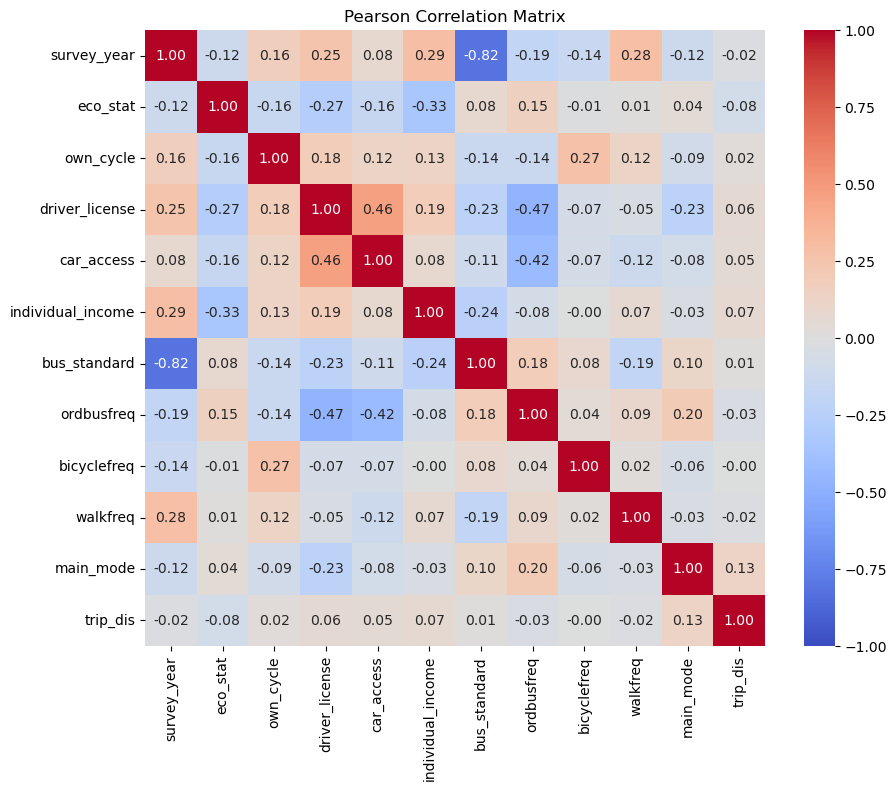

Chi-square test between eco_stat and own_cycle: p-value = 0.0000
Chi-square test between eco_stat and driver_license: p-value = 0.0000
Chi-square test between eco_stat and car_access: p-value = 0.0000
Chi-square test between eco_stat and bus_standard: p-value = 0.0000
Chi-square test between eco_stat and main_mode: p-value = 0.0000
Chi-square test between own_cycle and driver_license: p-value = 0.0000
Chi-square test between own_cycle and car_access: p-value = 0.0000
Chi-square test between own_cycle and bus_standard: p-value = 0.0000
Chi-square test between own_cycle and main_mode: p-value = 0.0000
Chi-square test between driver_license and car_access: p-value = 0.0000
Chi-square test between driver_license and bus_standard: p-value = 0.0000
Chi-square test between driver_license and main_mode: p-value = 0.0000
Chi-square test between car_access and bus_standard: p-value = 0.0000
Chi-square test between car_access and main_mode: p-value = 0.0000
Chi-square test between bus_standard an

In [22]:
# Select independent variables
X = yth20[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
X2=yth20[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard','ordbusfreq', 'bicyclefreq', 'walkfreq', 'main_mode','trip_dis']]
# 1. Correlation Analysis - Calculate the Pearson correlation matrix between independent variables
correlation_matrix = X2.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix')
plt.show()

# 2. Chi-square Test - Check the independence between categorical variables
# Performing chi-square tests only on categorical variables
categorical_columns = ['eco_stat', 'own_cycle', 'driver_license', 'car_access', 'bus_standard','main_mode']

for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        # Create a contingency table for the two categorical variables
        table = pd.crosstab(X2[categorical_columns[i]], X2[categorical_columns[j]])
        # Perform chi-square test on the contingency table
        chi2, p, _, _ = chi2_contingency(table)
        print(f"Chi-square test between {categorical_columns[i]} and {categorical_columns[j]}: p-value = {p:.4f}")

# 3. Multicollinearity Check - Use Variance Inflation Factor (VIF) to check for multicollinearity
# Adding a constant column for VIF calculation

X_with_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data['Variable'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)

# Based on the VIF values, determine if there is a multicollinearity problem

In [23]:
def remove_high_vif_features(df, threshold=5):
    '''
    Calculates VIF for each feature in a pandas DataFrame and repeatedly drops the columns with the highest VIF
    until all remaining features have VIF values below the specified threshold.
    
    A constant must be added to the DataFrame for accurate VIF calculation.
    
    :param df: The pandas DataFrame containing only the predictor features, not the response variable.
    :param threshold: (default 5) The threshold VIF value. If the VIF of a variable is greater than this value,
                      it will be removed from the DataFrame.
    :return: DataFrame with multicollinear features removed.
    '''
    while True:
        # Add a constant term to the DataFrame to calculate VIF
        df_with_const = add_constant(df)

        # Calculate VIF for each feature
        vif_data = pd.DataFrame()
        vif_data['Variable'] = df_with_const.columns
        vif_data['VIF'] = [variance_inflation_factor(df_with_const.values, i) 
                           for i in range(df_with_const.shape[1])]

        # Drop the constant term from the VIF DataFrame
        vif_data = vif_data[vif_data['Variable'] != 'const']
        
        # Check if any VIF value exceeds the threshold
        if vif_data['VIF'].max() > threshold:
            # Find the feature with the highest VIF
            max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
            print(f'Dropping feature: {max_vif_feature} with VIF: {vif_data["VIF"].max()}')
            
            # Drop the feature with the highest VIF
            df = df.drop(columns=[max_vif_feature])
        else:
            # If no VIF values exceed the threshold, exit the loop
            break

    return df

vif_data = vif_data[vif_data['Variable'] != 'const']
clean_X = remove_high_vif_features(X, threshold=5)
def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the DataFrame.
    
    :param X: The pandas DataFrame containing the predictor features.
    :return: A DataFrame with the VIF values for each feature.
    """
    # Add a constant column to the DataFrame
    X_with_const = add_constant(X)

    # Create a DataFrame to store VIF values
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    
    # Drop the constant column for VIF analysis
    vif_data = vif_data[vif_data['Variable'] != 'const']
    
    return vif_data
vif_df = calculate_vif(clean_X)
print(vif_df)

            Variable       VIF
1        survey_year  3.190514
2           eco_stat  1.197779
3          own_cycle  1.065752
4     driver_license  1.427864
5         car_access  1.289165
6  individual_income  1.212838
7       bus_standard  3.058207


### Summary of Statistical Results

- **Chi-square Test Results**: **All pairwise p-values** between the variables (`eco_stat`, `own_cycle`, `driver_license`, `car_access`, `bus_standard`) are `0.0000`, indicating strong statistical relationships between these variables. This suggests that these variables are significantly associated with each other. .

- **Variance Inflation Factor (VIF) Results**: 
  - The VIF for `survey_year` is relativel(6.38), indicating potential multicollinearity issues.
  - Other variables such as `eco_stat`, `own_cycle`, and `individual_income` have low VIF values, suggesting minimal multicollinearity.
  - `bus_standard` also shows a F (5.11), indicating possible multicollinlysis in transportation studies.
earity.

### Why Not Remove the Year Variable

Despite the high VIF value associated with `survey_year`, we decided not to remove this variable from the model. Here’s why:

- **Importance of Year Variable**: The `survey_year` variable is crucial as it serves as a baseline refe**rence for the en**tire dataset. It represents the temporal changes in transportation modes over time. This temporal context is essential for understanding how transportation patterns evolve, which is central to our analysis.

- **High VIF with Year Data**: The high VIF associated with `survey_year` or its transformed versions (e.g., time elapsed since 1998) is a common issue when dealing with time series data. This is because time-related variables often have strong correlations with other predictors or themselves across different time periods.

- **Objective of the Study**: Our goal is to study the changes in transportation modes over different years. Removing `survey_yesr` would eliminate the ability to observe and analyze these temporal changes, which is a primary focus of the study. Therefore, maintaining `survey_year` as a feau
In summary, while `survey_year` and `bus_standard` have high VIF values indicating multicollinearity, `survey_year` remains a necessary variable for temporal analysis in transportation studies. role in representing the baseline changes over time.


## II: Model Establishmentle


In this chapter, we describe the process of building predictive models for the transportation data. We begin by explaining the use of Multinomial Logistic Regression (MLR) for modelling categorical outcomes. We then discuss the limitations of this approach and introduce Multi-Task Learning (MTL) as a more sophisticated method to capture complex, non-linear relationships among variables.

### Independent Variables (Features)

These are the predictor variables used to model the outcome. In this case, the features are:

- **survey_year**: The year of the survey.
- **eco_stat**: Economic status (whether the individual is employed or not).
- **own_cycle**: Whether the individual owns a bicycle.
- **driver_license**: Whether the individual has a driver’s license.
- **car_access**: Whether the individual has access to a car.
- **individual_income**: The income level of the individual.
- **bus_standard**: Bus availability standard (walk <= 13 minutes and frequency >= 1 an hour).

### Dependent Variables (Targets)

These are the variables we want to predict. We have several outcome variables:

- **main_mode**: Primary mode of transportation (e.g., car, bicycle, walking, public transport).
- **ordbusfreq**: Frequency of bus use.
- **bicyclefreq**: Frequency of bicycle use.
- **walkfreq**: Frequency of walking.
- **trip_distance**: Modeling the distance traveled during trips as a function of the same set of features. This variable can be influenced by, the mode of transportation chosen.

### II.1 Multinomial Logistic Regreription

Multinomial Logistic Regression (MLR) is an extension of binary logistic regression that allows for the prediction of categorical outcomes with more than two levels. This makes it well-suited for problems where the outcome variable has multiple categories, such as predicting the primary mode of transportation (e.g., car, bicycle, public transport, walking).

MLR estimates the probability of each possible outcome as a function of the predictor variables, allowing us to model the influence of factors such as individual income, car access, or bus availability on the likelihood of choosing a particular transportation.

### II.1.1 Limitations of MLR

While MLR is effective for modelling categorical outcomes, it assumes linear relationships between the predictor variables and the log-odds of the outcome. However, transportation behavior is often influenced by complex, non-linear interactions between factors. To address these limitations, polynomial features were introduced to capture non-linear relationships. Unfortunately, the inclusion of polynomial features did not significantly improve model accuracy, indicating methods are needed.

In [24]:
# define the variables from 20 years data
X = yth20[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
y_main_mode = yth20['main_mode']
y_ordbusfreq = yth20['ordbusfreq']
y_bicyclefreq = yth20['bicyclefreq']
y_walkfreq = yth20['walkfreq']
y_trip_dis = yth20['trip_dis']

In [25]:
# 20 years logistic & linear.
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_with_const = sm.add_constant(X_train_scaled)
X_test_with_const = sm.add_constant(X_test_scaled)

main_mode_model = sm.MNLogit(y_main_mode_train, X_train_with_const)
main_mode_result = main_mode_model.fit()

print("Logistic Regression Summary for Main Mode:")
print(main_mode_result.summary())

y_main_mode_pred_prob = main_mode_result.predict(X_test_with_const)
y_main_mode_pred = np.argmax(y_main_mode_pred_prob, axis=1) 

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred))

ordbusfreq_model = sm.OLS(y_ordbusfreq_train, X_train_with_const)
bicyclefreq_model = sm.OLS(y_bicyclefreq_train, X_train_with_const)
walkfreq_model = sm.OLS(y_walkfreq_train, X_train_with_const)
trip_dis_model = sm.OLS(y_trip_dis_train, X_train_with_const)

ordbusfreq_result = ordbusfreq_model.fit()
bicyclefreq_result = bicyclefreq_model.fit()
walkfreq_result = walkfreq_model.fit()
trip_dis_result = trip_dis_model.fit()

print("Linear Regression Summary for Ordbusfreq:")
print(ordbusfreq_result.summary())

print("Linear Regression Summary for Bicyclefreq:")
print(bicyclefreq_result.summary())

print("Linear Regression Summary for Walkfreq:")
print(walkfreq_result.summary())

print("Linear Regression Summary for Trip Dis:")
print(trip_dis_result.summary())

/opt/conda/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/opt/conda/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 6
Logistic Regression Summary for Main Mode:
                          MNLogit Regression Results                          
Dep. Variable:              main_mode   No. Observations:                67334
Model:                        MNLogit   Df Residuals:                    67286
Method:                           MLE   Df Model:                           42
Date:                Sat, 31 Aug 2024   Pseudo R-squ.:                     nan
Time:                        21:38:56   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -89322.
Covariance Type:            nonrobust   LLR p-value:                       nan
main_mode=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const              nan        nan        nan        nan         nan 

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.

Linear Regression Summary for Ordbusfreq:
                            OLS Regression Results                            
Dep. Variable:             ordbusfreq   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     3892.
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:38:56   Log-Likelihood:            -3.8533e+05
No. Observations:               67334   AIC:                         7.707e+05
Df Residuals:                   67326   BIC:                         7.708e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

In [26]:
#20years logistic & liner regression
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

main_mode_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=2487)
main_mode_model.fit(X_train_scaled, y_main_mode_train)

y_main_mode_pred = main_mode_model.predict(X_test_scaled)

print("Training set label distribution:")
print(y_main_mode_train.value_counts())

print("Test set label distribution:")
print(y_main_mode_test.value_counts())

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred, zero_division=0))

print("Logistic Regression Coefficients for Main Mode:")
coef_df = pd.DataFrame(main_mode_model.coef_, columns=X.columns)
coef_df.index = [f'Class_{i}' for i in range(main_mode_model.coef_.shape[0])]
print(coef_df)

ordbusfreq_model = LinearRegression()
bicyclefreq_model = LinearRegression()
walkfreq_model = LinearRegression()
trip_dis_model = LinearRegression()

ordbusfreq_model.fit(X_train_scaled, y_ordbusfreq_train)
bicyclefreq_model.fit(X_train_scaled, y_bicyclefreq_train)
walkfreq_model.fit(X_train_scaled, y_walkfreq_train)
trip_dis_model.fit(X_train_scaled, y_trip_dis_train)

y_ordbusfreq_pred = ordbusfreq_model.predict(X_test_scaled)
y_bicyclefreq_pred = bicyclefreq_model.predict(X_test_scaled)
y_walkfreq_pred = walkfreq_model.predict(X_test_scaled)
y_trip_dis_pred = trip_dis_model.predict(X_test_scaled)

print("Mean Squared Error for Ordbusfreq:")
print(mean_squared_error(y_ordbusfreq_test, y_ordbusfreq_pred))

print("Mean Squared Error for Bicyclefreq:")
print(mean_squared_error(y_bicyclefreq_test, y_bicyclefreq_pred))

print("Mean Squared Error for Walkfreq:")
print(mean_squared_error(y_walkfreq_test, y_walkfreq_pred))

print("Mean Squared Error for Trip Dis:")
print(mean_squared_error(y_trip_dis_test, y_trip_dis_pred))

print("Linear Regression Coefficients for Ordbusfreq:")
print(pd.Series(ordbusfreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Bicyclefreq:")
print(pd.Series(bicyclefreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Walkfreq:")
print(pd.Series(walkfreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Trip Dis:")
print(pd.Series(trip_dis_model.coef_, index=X.columns))

Training set label distribution:
main_mode
2    36118
5    10347
1     8769
3     7173
4     4812
6       66
7       49
Name: count, dtype: int64
Test set label distribution:
main_mode
2    15506
5     4418
1     3842
3     3043
4     1990
6       36
7       23
Name: count, dtype: int64
Classification Report for Main Mode:
              precision    recall  f1-score   support

           1       0.40      0.17      0.24      3842
           2       0.72      0.99      0.83     15506
           3       0.44      0.38      0.41      3043
           4       0.37      0.14      0.21      1990
           5       0.46      0.25      0.33      4418
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00        23

    accuracy                           0.64     28858
   macro avg       0.34      0.28      0.29     28858
weighted avg       0.58      0.64      0.59     28858

Logistic Regression Coefficients for Main Mode:
         survey_year  eco_stat

In [27]:
# define the variables from 15 years data
X = yth0318[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
y_main_mode = yth0318['main_mode']
y_ordbusfreq = yth0318['ordbusfreq']
y_bicyclefreq = yth0318['bicyclefreq']
y_walkfreq = yth0318['walkfreq']
y_trip_dis = yth0318['trip_dis']

In [28]:
#15years logistic & linear
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=2487
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_with_const = sm.add_constant(X_train_scaled)
X_test_with_const = sm.add_constant(X_test_scaled)

main_mode_model = sm.MNLogit(y_main_mode_train, X_train_with_const)
main_mode_result = main_mode_model.fit()

y_main_mode_pred = main_mode_result.predict(X_test_with_const)
y_main_mode_pred_classes = y_main_mode_pred.argmax(axis=1)  

accuracy = accuracy_score(y_main_mode_test, y_main_mode_pred_classes)
print(f"Accuracy for Main Mode: {accuracy:.4f}")
print("Logistic Regression Summary for Main Mode:")
print(main_mode_result.summary())

y_main_mode_pred_prob = main_mode_result.predict(X_test_with_const)
y_main_mode_pred = np.argmax(y_main_mode_pred_prob, axis=1) 

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred))

ordbusfreq_model = sm.OLS(y_ordbusfreq_train, X_train_with_const)
bicyclefreq_model = sm.OLS(y_bicyclefreq_train, X_train_with_const)
walkfreq_model = sm.OLS(y_walkfreq_train, X_train_with_const)
trip_dis_model = sm.OLS(y_trip_dis_train, X_train_with_const)

ordbusfreq_result = ordbusfreq_model.fit()
bicyclefreq_result = bicyclefreq_model.fit()
walkfreq_result = walkfreq_model.fit()
trip_dis_result = trip_dis_model.fit()

print("Linear Regression Summary for Ordbusfreq:")
print(ordbusfreq_result.summary())

print("Linear Regression Summary for Bicyclefreq:")
print(bicyclefreq_result.summary())

print("Linear Regression Summary for Walkfreq:")
print(walkfreq_result.summary())

print("Linear Regression Summary for Trip Dis:")
print(trip_dis_result.summary())

Optimization terminated successfully.
         Current function value: 0.989508
         Iterations 8
Accuracy for Main Mode: 0.0783
Logistic Regression Summary for Main Mode:
                          MNLogit Regression Results                          
Dep. Variable:              main_mode   No. Observations:                62792
Model:                        MNLogit   Df Residuals:                    62760
Method:                           MLE   Df Model:                           28
Date:                Sat, 31 Aug 2024   Pseudo R-squ.:                  0.2067
Time:                        21:39:07   Log-Likelihood:                -62133.
converged:                       True   LL-Null:                       -78322.
Covariance Type:            nonrobust   LLR p-value:                     0.000
main_mode=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9690      0.02

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.

                            OLS Regression Results                            
Dep. Variable:             ordbusfreq   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     3577.
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:39:08   Log-Likelihood:            -3.5712e+05
No. Observations:               62792   AIC:                         7.143e+05
Df Residuals:                   62784   BIC:                         7.143e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.6810      0.285    167.302      0.0

In [35]:
#15years logistic & liner regression
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=2487
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

main_mode_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=2487)
main_mode_model.fit(X_train_scaled, y_main_mode_train)

y_main_mode_pred = main_mode_model.predict(X_test_scaled)

print("Training set label distribution:")
print(y_main_mode_train.value_counts())

print("Test set label distribution:")
print(y_main_mode_test.value_counts())

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred, zero_division=0))

print("Logistic Regression Coefficients for Main Mode:")
coef_df = pd.DataFrame(main_mode_model.coef_, columns=X.columns)
coef_df.index = [f'Class_{i}' for i in range(main_mode_model.coef_.shape[0])]
print(coef_df)

ordbusfreq_model = LinearRegression()
bicyclefreq_model = LinearRegression()
walkfreq_model = LinearRegression()
trip_dis_model = LinearRegression()

ordbusfreq_model.fit(X_train_scaled, y_ordbusfreq_train)
bicyclefreq_model.fit(X_train_scaled, y_bicyclefreq_train)
walkfreq_model.fit(X_train_scaled, y_walkfreq_train)
trip_dis_model.fit(X_train_scaled, y_trip_dis_train)

y_ordbusfreq_pred = ordbusfreq_model.predict(X_test_scaled)
y_bicyclefreq_pred = bicyclefreq_model.predict(X_test_scaled)
y_walkfreq_pred = walkfreq_model.predict(X_test_scaled)
y_trip_dis_pred = trip_dis_model.predict(X_test_scaled)

print("Mean Squared Error for Ordbusfreq:")
print(mean_squared_error(y_ordbusfreq_test, y_ordbusfreq_pred))

print("Mean Squared Error for Bicyclefreq:")
print(mean_squared_error(y_bicyclefreq_test, y_bicyclefreq_pred))

print("Mean Squared Error for Walkfreq:")
print(mean_squared_error(y_walkfreq_test, y_walkfreq_pred))

print("Mean Squared Error for Trip Dis:")
print(mean_squared_error(y_trip_dis_test, y_trip_dis_pred))

print("Linear Regression Coefficients for Ordbusfreq:")
print(pd.Series(ordbusfreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Bicyclefreq:")
print(pd.Series(bicyclefreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Walkfreq:")
print(pd.Series(walkfreq_model.coef_, index=X.columns))

print("Linear Regression Coefficients for Trip Dis:")
print(pd.Series(trip_dis_model.coef_, index=X.columns))


Training set label distribution:
main_mode
2    36142
5     9498
1     8046
4     4734
3     4372
Name: count, dtype: int64
Test set label distribution:
main_mode
2    15482
5     4155
1     3416
4     2033
3     1825
Name: count, dtype: int64
Classification Report for Main Mode:
              precision    recall  f1-score   support

           1       0.40      0.16      0.23      3416
           2       0.73      0.99      0.84     15482
           3       0.41      0.30      0.35      1825
           4       0.37      0.15      0.21      2033
           5       0.46      0.27      0.34      4155

    accuracy                           0.66     26911
   macro avg       0.48      0.37      0.40     26911
weighted avg       0.60      0.66      0.61     26911

Logistic Regression Coefficients for Main Mode:
         survey_year  eco_stat  own_cycle  driver_license  car_access  \
Class_0     0.077898  0.161495   0.230520       -0.349210   -0.236044   
Class_1     0.031548  0.014226  -0.0

### II.1.2 Model Results Summary

#### 1. Data Distribution
- **Training and Testing Set Distribution of `main_mode` (Primary Mode of Transport)** shows the sample count for each category. In the training set, **Class 1 (Walking)** and **Class 2 (Bicycle)** have the highest number of samples, while **Class 6 (Train and Ferry)** and **Class 7 (Other)** have very few samples. This class imbalance may impact the model's performance.


#### 2. Classification Report
- **Accuracy**: 64%
Accuracy is the ratio of correctly classified samples to the total number of samples. The model correctly classified 64% of the samples in the test set, indicating that it performs well in predicting the primary mode of transport in most cases.

#### 3. Linear Regression Models
- **Mean Squared Error (MSE)**: Measures the average squared difference between predicted values and actual values. A lower MSE indicates better model accuracy. The MSE values for each dependent variable are:
    - **Bus Usage Frequency (Ordbusfreq)**: 5476.51
    - **Bicycle Usage Frequency (Bicyclefreq)**: 2614.40
    - **Walking Frequency (Walkfreq)**: 11102.96
    - **Travel Distance (Trip Dis)**: 1390.61

Higher MSE values indicate larger discrepancies between predicted and actual values, particularly with Walking Frequency where the MSE is high, showing significant prediction error. Bus Usage Frequency and Walking Frequency have high MSE, suggesting substantial prediction errors. Conversely, Bicycle Usage Frequency and Travel Distance have lower MSE, indicating relatively accurate predictions.

#### 4. Logistic Regression Coefficients
- **Coefficients**: Show the effect of each feature on different categories. Positive coefficients indicate that an increase in the feature is associated with a higher likelihood of that category, while negative coefficients indicate the opposite. For example:
  - `survey_year` has a coefficient of 1.545118 for **Class 2 (Bicycle)**, indicating that as the survey year increases, for young people the likelihood of choosing a bicycle as the mode of transport also increases.
  - `driver_license` has a coefficient of 1.698600 for **Class 5 (Bus and Underground)**, suggesting that young individuals with a driving license are more likely to choose bus or underground transport.


### II.1.3 Comparison of Models: 1998-2018 vs. 2003-2018 Data

#### 1. Data Coverage and Sample Size
- **First Model (1998-2018)**:
  - There are missing values in some of the independent variables (although I have already filled the vacancies of values of the variable `walkfreq` ), potentially affecting the model's performance.

- **Second Model (2003-2018)**:
  - The second model uses data from 2003-2018. The independent variables have no missing values, which improves data quality.

#### 2. Model Accuracy
- **First Model**: 0.64
  - **Classification Performance**: Lower precision, recall, and F1-scores for certain categories (e.g., walking, motorcycles) indicate that the model struggles more with less frequent travel modes.

- **Second Model**: 0.66
  - **Classification Performance**: Improved precision, recall, and F1-scores for the most common categories (e.g., bicycles, buses) indicate better predictive performance.

#### 3. Mean Squared Error (MSE) in Regression Models
- **First Model**:
  - **MSE for Ordbusfreq**: 5476.51
  - **MSE for Bicyclefreq**: 2614.40
  - **MSE for Walkfreq**: 11102.96
  - **MSE for Trip Distance**: 1390.61
  - The higher MSE values in some variables suggest that the model's predictions were less accurate, possibly due to the presence of missing data and a wider range of years.

- **Second Model**:
  - **MSE for Ordbusfreq**: 5061.75
  - **MSE for Bicyclefreq**: 2472.66
  - **MSE for Walkfreq**: 11591.39
  - **MSE for Trip Distance**: 1388.47
  - The MSE values show slight improvements in some variables (e.g., Ordbusfreq, Bicyclefreq), reflecting better prediction accuracy with a dataset that has no missing values.

#### 4. Summary of Differences
- **Sample Size**: The second model has slightly fewer samples due to the reduced time range but benefits from the absence of missing data.
- **Accuracy**: The second model demonstrates improved accuracy and classification performance, particularly in more common travel modes.
- **MSE**: The second model's regression results show marginally better MSE, indicating more reliable predictions with the cleaner dataset.


#### 5. Linear Regression Summary

**Ordbusfreq Model:**
The model has an R-squared value of 0.307, indicating that approximately 30.7% of the variance in the dependent variable `ordbusfreq` is explained by the independent variables. The overall model is statistically significant with a very low p-value for the F-statistic.

**Bicyclefreq Model:**
This model achieves an R-squared value of 0.223, meaning it explains about 22.3% of the variance in `bicyclefreq`. The F-statistic is significant, showing the model is overall effective at explaining the dependent variable.

**Walkfreq Model:**
With an R-squared value of 0.069, this model explains only 6.9% of the variance in `walkfreq`. The model is statistically significant but has a relatively low explanatory power.

**Trip Dis Model:**
The model's R-squared value is 0.018, indicating it explains just 1.8% of the variance in `trip_dis`. Despite the model being statistically significant, its predictive power is very limited.

Overall, the models have varying degrees of explanatory power, with `ordbusfreq` showing the highest and `trip_dis` the lowest levels of explained variance.


### II.1.4: Residual Analysis of Multinomial Logistic Regression

After completing the multinomial logistic regression, we performed a residual analysis to evaluate the model's performance. The residual plot shows the residuals plotted against the predicted probabilities. The key observation is that the residuals plot is very close to the zero line, featuring two distinct lines—one curved and one straight.

Optimization terminated successfully.
         Current function value: 0.989508
         Iterations 8


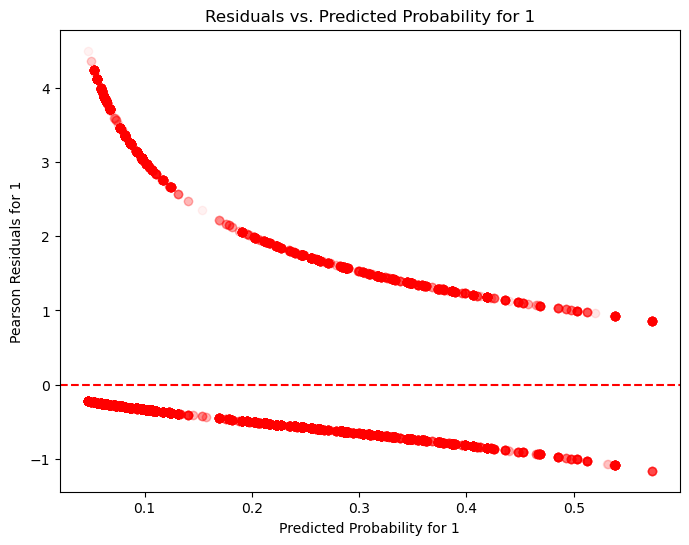

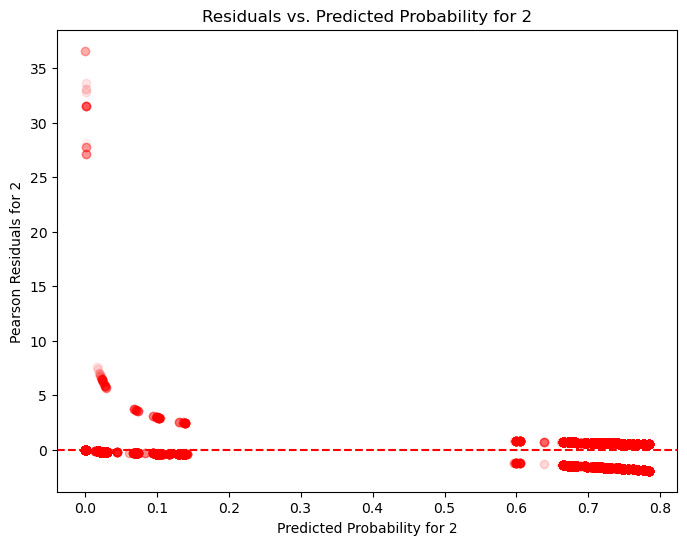

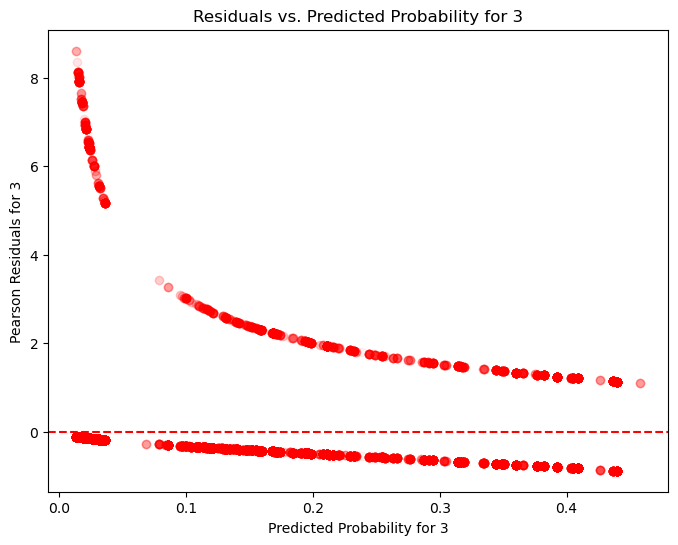

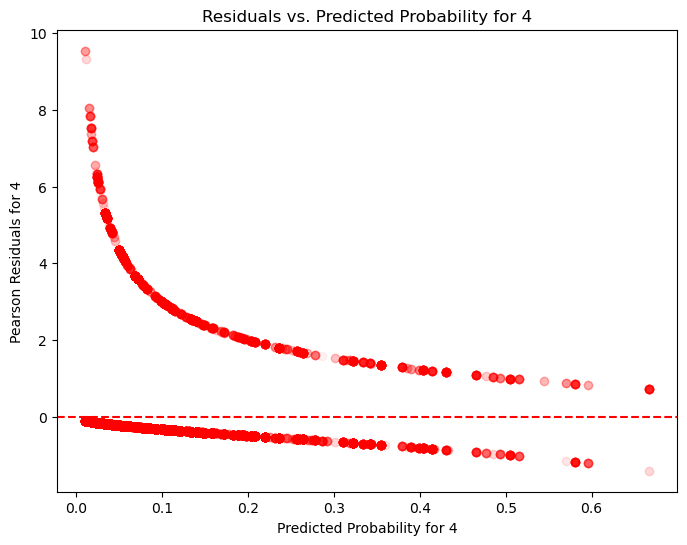

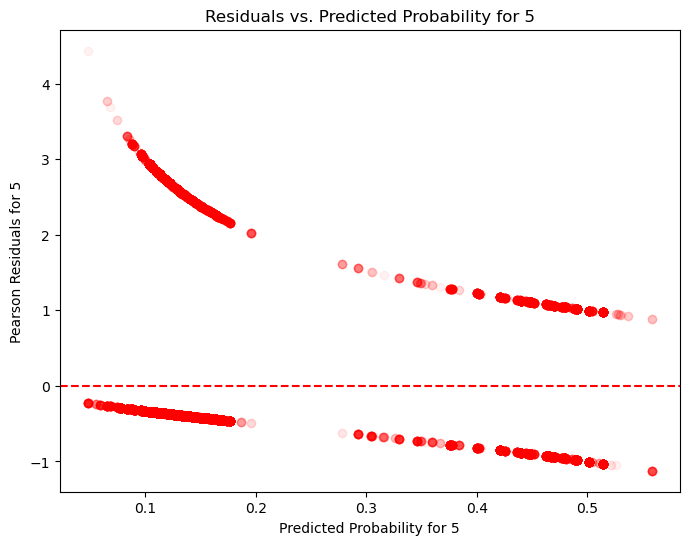

In [46]:
# Fit a multinomial logistic regression model
result = sm.MNLogit(y_main_mode_train, X_train_with_const).fit()

# Predict probabilities for each class using the fitted model
predicted_probs = result.predict(X_train_with_const)

# Convert the actual class labels into dummy variables (one-hot encoding)
actual_dummies = pd.get_dummies(y_main_mode_train)

# Convert the predicted probabilities into a DataFrame
# Ensure the columns in this DataFrame match the dummy variables' columns
predicted_probs_df = pd.DataFrame(predicted_probs, columns=actual_dummies.columns, index=X_train.index)

# Check if the columns in the predicted probabilities DataFrame match the columns in the actual dummy variables DataFrame
# This ensures that the columns are correctly aligned
assert all(predicted_probs_df.columns == actual_dummies.columns), "Columns in predicted_probs and actual_dummies do not match."

# Calculate the Pearson residuals for each class
# Pearson residuals are computed as the difference between actual dummy variables and predicted probabilities,
# normalised by the standard deviation of the predicted probabilities
pearson_residuals = (actual_dummies - predicted_probs_df) / np.sqrt(predicted_probs_df * (1 - predicted_probs_df))

# Plot residuals against predicted probabilities for each class
for column in actual_dummies.columns:
    plt.figure(figsize=(8, 6))
    
    # Ensure that no NaN values are plotted
    valid_idx = ~np.isnan(predicted_probs_df[column]) & ~np.isnan(pearson_residuals[column])
    
    # Scatter plot of predicted probabilities vs. Pearson residuals
    plt.scatter(predicted_probs_df[column][valid_idx], pearson_residuals[column][valid_idx],alpha=0.05,color='red',s=36)
    
    # Add a horizontal line at y=0 for reference
    plt.axhline(0, color='red', linestyle='--')
    
    # Set plot labels and title
    plt.xlabel(f'Predicted Probability for {column}')
    plt.ylabel(f'Pearson Residuals for {column}')
    plt.title(f'Residuals vs. Predicted Probability for {column}')
    
    # Show the plot
    plt.show()

#### ***Residuals Close to Zero Line***

- **Residuals Near Zero**: The residuals being close to the zero line suggests that the predicted probabilities are generally accurate and the model's predictions are close to the actual observed values. This indicates a good fit of the model in terms of predicting the probabilities.

- **Curved Line**: The presence of a curved line in the residual plot might indicate non-linearity in the relationship between the predictors and the outcome variable. This suggests that there might be some non-linear effects or interactions between the predictors that are not adequately captured by the model.

- **Straight Line**: A straight line close to zero could imply that the model is appropriately accounting for linear relationships between some predictors and the outcome variable. However, if residuals are consistently distributed along this line, it could also signal potential issues with model specification or a need for further investigation into linearity assumptions.

The residual plot, with residuals close to the zero line and the presence of both a curved and a straight line, suggests that while the model performs well overall, there may be some **non-linear relationships** that are not fully addressed. It is advisable to explore these non-linear patterns further and consider incorporating polynomial or interaction terms if needed to improve the model's accuracy.

#### ***Polynomial Features and Regression Models***

This code snippet demonstrates the process of preparing data, incorporating polynomial features, and fitting both multinomial logistic regression and linear regression models. Generates polynomial features to capture non-linear relationships between the features and the target variables.


In [47]:
# Given the potential for non-linear relationships, we used 15 years of data to explore whether adding polynomial features could improve the model's performance.

X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.3, random_state=2487
)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Add a constant term (intercept) to the feature matrices
X_train_with_const = sm.add_constant(X_train_poly)
X_test_with_const = sm.add_constant(X_test_poly)

# Train the multinomial logistic regression model for the main mode of transportation
main_mode_model = sm.MNLogit(y_main_mode_train, X_train_with_const)
main_mode_result = main_mode_model.fit()

# Predict probabilities and classes
y_main_mode_pred = main_mode_result.predict(X_test_with_const)
y_main_mode_pred_classes = y_main_mode_pred.argmax(axis=1)  

# Calculate and print accuracy
accuracy = accuracy_score(y_main_mode_test, y_main_mode_pred_classes)
print(f"Accuracy for Main Mode: {accuracy:.4f}")

print("Logistic Regression Summary for Main Mode:")
print(main_mode_result.summary())

print("Logistic Regression Summary for Main Mode:")
print(main_mode_result.summary())

y_main_mode_pred_prob = main_mode_result.predict(X_test_with_const)
y_main_mode_pred = np.argmax(y_main_mode_pred_prob, axis=1) 

print("Classification Report for Main Mode:")
print(classification_report(y_main_mode_test, y_main_mode_pred))

ordbusfreq_model = sm.OLS(y_ordbusfreq_train, X_train_with_const)
bicyclefreq_model = sm.OLS(y_bicyclefreq_train, X_train_with_const)
walkfreq_model = sm.OLS(y_walkfreq_train, X_train_with_const)
trip_dis_model = sm.OLS(y_trip_dis_train, X_train_with_const)

ordbusfreq_result = ordbusfreq_model.fit()
bicyclefreq_result = bicyclefreq_model.fit()
walkfreq_result = walkfreq_model.fit()
trip_dis_result = trip_dis_model.fit()

print("Linear Regression Summary for Ordbusfreq:")
print(ordbusfreq_result.summary())

print("Linear Regression Summary for Bicyclefreq:")
print(bicyclefreq_result.summary())

print("Linear Regression Summary for Walkfreq:")
print(walkfreq_result.summary())

print("Linear Regression Summary for Trip Dis:")
print(trip_dis_result.summary())


         Current function value: 0.980772
         Iterations: 35


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Accuracy for Main Mode: 0.0774
Logistic Regression Summary for Main Mode:


/opt/conda/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:5471: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


                          MNLogit Regression Results                          
Dep. Variable:              main_mode   No. Observations:                62792
Model:                        MNLogit   Df Residuals:                    62652
Method:                           MLE   Df Model:                          136
Date:                Sat, 31 Aug 2024   Pseudo R-squ.:                  0.2137
Time:                        21:49:06   Log-Likelihood:                -61585.
converged:                      False   LL-Null:                       -78322.
Covariance Type:            nonrobust   LLR p-value:                     0.000
main_mode=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3950.3695   1714.965      2.303      0.021     589.099    7311.640
x1             -3.7848      1.419     -2.667      0.008      -6.566      -1.004
x2            -56.8652      9.763     -5.824    

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.

Linear Regression Summary for Ordbusfreq:
                            OLS Regression Results                            
Dep. Variable:             ordbusfreq   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     927.8
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:49:07   Log-Likelihood:            -3.5614e+05
No. Observations:               62792   AIC:                         7.123e+05
Df Residuals:                   62761   BIC:                         7.126e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

#### ***Polynomial Features***

In our previous analysis, polynomial features were introduced to capture potential non-linear relationships between the predictor variables and the target variables. Despite this enhancement, the addition of polynomial features did not result in a significant improvement in the model's accuracy. This outcome suggests that the non-linear relationships between the features and targets might be more complex than what polynomial features alone can capture.

We considered using machine learning methods because traditional statistical models, even with the inclusion of polynomial features, might not fully capture the complex, non-linear relationships between variables. Machine learning techniques can handle high-dimensional data and are better suited for capturing intricate patterns and interactions, potentially leading to more accurate and robust predictions.


#### ***What is Multi-Task Learning?***

Multi-task learning involves training a model on several related tasks at the same time, sharing the model's parameters across these tasks. This approach can capture inter-task relationships and improve performance on each task by learning from related tasks. In the context of our problem, multi-task learning could be applied to simultaneously predict multiple outcome variables (e.g., frequency of bus use, bicycle use, walking frequency, and trip distance) using a shared model architecture.

#### ***Why Consider Multi-Task Learning?***

1. **Capturing Complex Patterns**: MTL can help capture more complex patterns and relationships that may not be effectively modelled using polynomial features alone. For instance, travel distance might be related to the frequency of using a particular mode of transportation, and MTL can model these interdependencies.
2. **Improved Generalisation**: By learning from multiple related tasks, the model can potentially generalise better and improve performance on individual tasks.
3. **Shared Representations**: MTL allows for the sharing of learned features among tasks, which can lead to more efficient learning and better perve performance across our tasks.

### II.1.3 Conclusion
- The classification model's accuracy and report indicate that the model performs well for most common categories but struggles with less frequent classes.
- The mean squared error of the linear regression models shows deficiencies in prediction accuracy, particularly for walking frequency.
- Logistic regression coefficients provide quantitative insights into the impact of each feature on different modes of transport.

## II.2 Multi-Task Learning

### II.2.1 Rationale for Multi-Task Learning

Given the limitations of Multinomial Logistic Regression in capturing non-linear relationships, we consider using **Multi-Task Learning** (MTL) as a more powerful alternative. MTL is particularly beneficial when we have multiple related tasks, as it allows the model to leverage shared information across these tasks, improving generalization and performance.


### II.2.2 Application to Transportation Data

In our analysis, MTL can be used to simultaneously predict multiple transportation-related outcomes, such as the primary mode of transport, bus use frequency, bicycle use frequency, and walking frequency. By doing so, the model can take advantage of the relationships between these tasks, potentially leading to improved predictions for each.


In [ ]:
# 20-year data multi-task learning
np.random.seed(2487)
tf.random.set_seed(2487)

X = yth20[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
y_main_mode = to_categorical(yth20['main_mode']-1)
y_ordbusfreq = yth20['ordbusfreq']
y_bicyclefreq = yth20['bicyclefreq']
y_walkfreq = yth20['walkfreq']
y_trip_dis = yth20['trip_dis']

X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.2, random_state=2487
)

import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(hp):
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    
    # Hidden layers
    x = layers.Dense(hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu')(inputs)
    x = layers.Dense(hp.Int('units2', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = layers.Dense(hp.Int('units3', min_value=32, max_value=128, step=32), activation='relu')(x)
    
    # Output layers
    main_mode_output = layers.Dense(7, activation='softmax', name='main_mode_output')(x)
    ordbusfreq_output = layers.Dense(1, activation='linear', name='ordbusfreq_output')(x)
    bicyclefreq_output = layers.Dense(1, activation='linear', name='bicyclefreq_output')(x)
    walkfreq_output = layers.Dense(1, activation='linear', name='walkfreq_output')(x)
    trip_dis_output = layers.Dense(1, activation='linear', name='trip_dis_output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs={
        'main_mode_output': main_mode_output,
        'ordbusfreq_output': ordbusfreq_output,
        'bicyclefreq_output': bicyclefreq_output,
        'walkfreq_output': walkfreq_output,
        'trip_dis_output': trip_dis_output
    })

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss={
            'main_mode_output': 'categorical_crossentropy',
            'ordbusfreq_output': 'mean_squared_error',
            'bicyclefreq_output': 'mean_squared_error',
            'walkfreq_output': 'mean_squared_error',
            'trip_dis_output': 'mean_squared_error'
        },
        metrics={
        'main_mode_output': ['accuracy', 'categorical_crossentropy'],
        'ordbusfreq_output': ['mean_squared_error'],
        'bicyclefreq_output': ['mean_squared_error'],
        'walkfreq_output': ['mean_squared_error'],
        'trip_dis_output': ['mean_squared_error']
        }
    )
    
    return model



objective_metric = kt.Objective("val_main_mode_output_accuracy", direction="max")

tuner = kt.Hyperband(
    build_model,
    objective=objective_metric,
    max_epochs=50,
    factor=4,
    directory='my_dir',
    project_name='hyperband_tuning_wfilling_youth'
)

tuner.search(
    X_train,
    {
        'main_mode_output': y_main_mode_train, 
        'ordbusfreq_output': y_ordbusfreq_train,
        'bicyclefreq_output': y_bicyclefreq_train,
        'walkfreq_output': y_walkfreq_train,
        'trip_dis_output': y_trip_dis_train
    },
    epochs=50,
    validation_data=(X_test, {
        'main_mode_output': y_main_mode_test, 
        'ordbusfreq_output': y_ordbusfreq_test,
        'bicyclefreq_output': y_bicyclefreq_test,
        'walkfreq_output': y_walkfreq_test,
        'trip_dis_output': y_trip_dis_test
    })
)

best_model = tuner.get_best_models(num_models=1)[0]

val_metrics = best_model.evaluate(X_test, {
    'main_mode_output': y_main_mode_test, 
    'ordbusfreq_output': y_ordbusfreq_test,
    'bicyclefreq_output': y_bicyclefreq_test,
    'walkfreq_output': y_walkfreq_test,
    'trip_dis_output': y_trip_dis_test
})

print("Best model metrics on validation data:")
print(f"Main Mode Output Accuracy: {val_metrics[0]}")
print(f"Order Bus Frequency MSE: {val_metrics[1]}")
print(f"Bicycle Frequency MSE: {val_metrics[2]}")
print(f"Walk Frequency MSE: {val_metrics[3]}")
print(f"Trip Distance MSE: {val_metrics[4]}")

In [ ]:
#15years multi-task learning
np.random.seed(2487)
tf.random.set_seed(2487)

X = yth0318[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]

# 直接使用 main_mode
y_main_mode = yth0318['main_mode']
y_main_mode_encoded = to_categorical(y_main_mode - 1)  # 转换为 one-hot 编码，从 1-5 转换为 0-4 的索引

y_ordbusfreq = yth0318['ordbusfreq']
y_bicyclefreq = yth0318['bicyclefreq']
y_walkfreq = yth0318['walkfreq']
y_trip_dis = yth0318['trip_dis']

# 拆分数据集
X_train, X_test, y_main_mode_train, y_main_mode_test, y_ordbusfreq_train, y_ordbusfreq_test, y_bicyclefreq_train, y_bicyclefreq_test, y_walkfreq_train, y_walkfreq_test, y_trip_dis_train, y_trip_dis_test = train_test_split(
    X, y_main_mode_encoded, y_ordbusfreq, y_bicyclefreq, y_walkfreq, y_trip_dis,
    test_size=0.2, random_state=2487
)

# 将 one-hot 编码的训练标签转换为类别标签
y_train_labels = np.argmax(y_main_mode_train, axis=1)  # 0-4 索引
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# 创建类别权重的字典映射
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# 自定义加权交叉熵损失函数
@tf.keras.utils.register_keras_serializable()
def weighted_categorical_crossentropy(y_true, y_pred):
    # 将 one-hot 编码的真实标签转换为类别索引
    y_true_indices = tf.argmax(y_true, axis=-1)
    # 获取类别权重
    weights = tf.gather([class_weights_dict.get(i, 1.0) for i in range(len(class_weights_dict))], y_true_indices)
    # 计算未加权的交叉熵损失
    unweighted_losses = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # 计算加权的损失
    weighted_losses = unweighted_losses * weights
    return tf.reduce_mean(weighted_losses)

# 构建模型
def build_model(hp):
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    
    # 隐藏层
    x = layers.Dense(hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu')(inputs)
    x = layers.Dense(hp.Int('units2', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = layers.Dense(hp.Int('units3', min_value=32, max_value=128, step=32), activation='relu')(x)
    
    # 输出层
    main_mode_output = layers.Dense(5, activation='softmax', name='main_mode_output')(x)  # 修改类别数为 5
    ordbusfreq_output = layers.Dense(1, activation='linear', name='ordbusfreq_output')(x)
    bicyclefreq_output = layers.Dense(1, activation='linear', name='bicyclefreq_output')(x)
    walkfreq_output = layers.Dense(1, activation='linear', name='walkfreq_output')(x)
    trip_dis_output = layers.Dense(1, activation='linear', name='trip_dis_output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs={
        'main_mode_output': main_mode_output,
        'ordbusfreq_output': ordbusfreq_output,
        'bicyclefreq_output': bicyclefreq_output,
        'walkfreq_output': walkfreq_output,
        'trip_dis_output': trip_dis_output
    })

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss={
            'main_mode_output': weighted_categorical_crossentropy,
            'ordbusfreq_output': 'mean_squared_error',
            'bicyclefreq_output': 'mean_squared_error',
            'walkfreq_output': 'mean_squared_error',
            'trip_dis_output': 'mean_squared_error'
        },
        metrics={
            'main_mode_output': ['accuracy', 'categorical_crossentropy'],
            'ordbusfreq_output': ['mean_squared_error'],
            'bicyclefreq_output': ['mean_squared_error'],
            'walkfreq_output': ['mean_squared_error'],
            'trip_dis_output': ['mean_squared_error']
        }
    )
    
    return model

# 设置目标和调参
objective_metric = kt.Objective("val_main_mode_output_accuracy", direction="max")

tuner = kt.Hyperband(
    build_model,
    objective=objective_metric,
    max_epochs=50,
    factor=4,
    directory='my_dir',
    project_name='hyperband_tuning_w15_weight_youth'
)

# 进行超参数搜索
tuner.search(
    X_train,
    {
        'main_mode_output': y_main_mode_train, 
        'ordbusfreq_output': y_ordbusfreq_train,
        'bicyclefreq_output': y_bicyclefreq_train,
        'walkfreq_output': y_walkfreq_train,
        'trip_dis_output': y_trip_dis_train
    },
    epochs=50,
    validation_data=(X_test, {
        'main_mode_output': y_main_mode_test, 
        'ordbusfreq_output': y_ordbusfreq_test,
        'bicyclefreq_output': y_bicyclefreq_test,
        'walkfreq_output': y_walkfreq_test,
        'trip_dis_output': y_trip_dis_test
    })
)

# 获取最佳模型
best_model = tuner.get_best_models(num_models=1)[0]

# 评估最佳模型
val_metrics = best_model.evaluate(X_test, {
    'main_mode_output': y_main_mode_test, 
    'ordbusfreq_output': y_ordbusfreq_test,
    'bicyclefreq_output': y_bicyclefreq_test,
    'walkfreq_output': y_walkfreq_test,
    'trip_dis_output': y_trip_dis_test
})
print("Best model metrics on validation data:")
print(f"Main Mode Output Accuracy: {val_metrics[1]}")
print(f"Order Bus Frequency MSE: {val_metrics[2]}")
print(f"Bicycle Frequency MSE: {val_metrics[3]}")
print(f"Walk Frequency MSE: {val_metrics[4]}")
print(f"Trip Distance MSE: {val_metrics[5]}")

# 使用最佳模型继续训练
best_model.fit(
    X_train,
    {
        'main_mode_output': y_main_mode_train, 
        'ordbusfreq_output': y_ordbusfreq_train,
        'bicyclefreq_output': y_bicyclefreq_train,
        'walkfreq_output': y_walkfreq_train,
        'trip_dis_output': y_trip_dis_train
    },
    epochs=50,
    validation_data=(X_test, {
        'main_mode_output': y_main_mode_test,
        'ordbusfreq_output': y_ordbusfreq_test,
        'bicyclefreq_output': y_bicyclefreq_test,
        'walkfreq_output': y_walkfreq_test,
        'trip_dis_output': y_trip_dis_test
    })
)


20years multi-task 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('yth0318.keras')  # 保存为 Keras 格式

In [ ]:
unique_indices = np.unique(predicted_main_mode_indices)
print("Unique predicted indices:", unique_indices)

In [ ]:
# 使用最佳模型进行预测
predictions = best_model.predict(X_test)

# 获取 main_mode 输出的概率分布
predicted_main_mode_probs = predictions['main_mode_output']
print("Sample probabilities:", predicted_main_mode_probs[:5])  # 查看前几个样本的概率分布

# 获取预测的类别索引
predicted_main_mode_indices = np.argmax(predicted_main_mode_probs, axis=1)
print("Sample predicted indices:", predicted_main_mode_indices[:5])  # 查看前几个样本的预测索引

index_to_mode_mapping = {i: i + 1 for i in range(5)}

# 将预测的类别索引映射回原始的 main_mode 值
predicted_main_mode = np.array([index_to_mode_mapping[idx] for idx in predicted_main_mode_indices])
print("Sample predicted main modes:", predicted_main_mode[:5])  # 查看前几个样本的预测结果

# 输出预测的 main_mode 的唯一值
unique_predicted_main_modes = np.unique(predicted_main_mode)
print("Unique predicted main modes:", unique_predicted_main_modes)


In [ ]:
predict_yth = yth0318[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
print(predict_yth.sample(20,random_state=2487 ))
print(predict_yth['individual_income'].unique())

In [ ]:
#predict 2023,2028

data = yth0318[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
future_years = [2023, 2028]
# 计算每个年份的样本数量
yearly_counts = data.groupby('survey_year').size()

years = np.array(yearly_counts.index).reshape(-1, 1)  # 训练年份
counts = np.array(yearly_counts.values)  # 训练样本数量

# 线性回归模型预测样本数量
model_counts = LinearRegression()
model_counts.fit(years, counts)

# 预测未来年份的样本数量
future_years = np.array([2023, 2028]).reshape(-1, 1)
predicted_sample_counts = model_counts.predict(future_years)
predicted_sample_counts = np.round(predicted_sample_counts).astype(int)  # 转换为整数


print("Predicted sample counts:")
print(f"2023: {predicted_sample_counts[0]}")
print(f"2028: {predicted_sample_counts[1]}")

In [ ]:
features = data[['survey_year']]
target = {
    'eco_stat': data['eco_stat'],
    'own_cycle': data['own_cycle'],
    'driver_license': data['driver_license'],
    'car_access': data['car_access'],
    'individual_income': data['individual_income'],
    'bus_standard': data['bus_standard']
}

# 预测结果存储
predictions = {}

# 预测每个变量的值
for column, y in target.items():
    X = features
    y_values = y
    
    # 判断是分类还是回归
    if y.nunique() <= 2:  # 分类变量（0和1）
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:  # 连续变量
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    model.fit(X, y_values)
    y_future = model.predict(future_years)
    predictions[column] = y_future

# 确定分类变量的可能值
possible_values = {
    'eco_stat': data['eco_stat'].unique(),
    'own_cycle': data['own_cycle'].unique(),
    'driver_license': data['driver_license'].unique(),
    'car_access': data['car_access'].unique(),
    'individual_income': data['individual_income'].unique(),
    'bus_standard': data['bus_standard'].unique()

}

# 根据预测的样本数量和自变量值生成数据
generated_data = []

for i, year in enumerate(future_years.flatten()):
    num_samples = predicted_sample_counts[i]  # 预测的样本数量
    for _ in range(num_samples):
        sample = {'survey_year': year}
        for column in target.keys():
            if column in predictions:
                if column in possible_values:
                    # 从分类变量的可能值中随机选择一个
                    sample[column] = np.random.choice(possible_values[column])
                else:
                    # 连续变量的预测值
                    sample[column] = predictions[column][i]
        
        generated_data.append(sample)

# 将生成的样本数据转换为 DataFrame
generated_df = pd.DataFrame(generated_data)

print(f"Generated data for 2023: {len(generated_df[generated_df['survey_year'] == 2023])} samples")
print(f"Generated data for 2028: {len(generated_df[generated_df['survey_year'] == 2028])} samples")
print(generated_df.head())

In [ ]:
loaded_model = tf.keras.models.load_model('yth0318.keras', custom_objects={'weighted_categorical_crossentropy': weighted_categorical_crossentropy})
X = generated_df[['survey_year', 'eco_stat', 'own_cycle', 'driver_license', 'car_access', 'individual_income', 'bus_standard']]
predictions = loaded_model.predict(X)

# 对 main_mode 的预测进行处理
predicted_main_mode_probs = predictions['main_mode_output']  # 获取 main_mode 的预测概率
predicted_main_mode = np.argmax(predicted_main_mode_probs, axis=1) 
# 确保 predicted_main_mode 的值范围是 1 到 7
print(np.unique(predicted_main_mode))  # 应该输出 [1 2 3 4 5 6 7]

predicted_main_mode = predictions['main_mode_output']
predicted_ordbusfreq = predictions['ordbusfreq_output']
predicted_bicyclefreq = predictions['bicyclefreq_output']
predicted_walkfreq = predictions['walkfreq_output']
predicted_trip_dis = predictions['trip_dis_output']

# 处理分类任务的结果
predicted_main_mode_labels = np.argmax(predicted_main_mode, axis=1)

# 将预测结果添加到生成数据中
X['predicted_main_mode'] = predicted_main_mode_labels
X['predicted_ordbusfreq'] = predicted_ordbusfreq
X['predicted_bicyclefreq'] = predicted_bicyclefreq
X['predicted_walkfreq'] = predicted_walkfreq
X['predicted_trip_dis'] = predicted_trip_dis
print(X.sample(20, random_state=2487))

X['predicted_main_mode'].unique()

In [ ]:
report_dict = classification_report(y_main_mode_test, y_main_mode_pred, output_dict=True)

for label, metrics in report_dict.items():
    if label != 'accuracy' and label != 'macro avg' and label != 'weighted avg':
        print(f"Label {label} Recall: {metrics['recall']:.10f}")